# CLEANING DES DONNEES DU DATASET PRODUCTION ENERGIE EN FRANCE

_ jeu de données vierge en téléchargement libre ici : 
https://opendata.reseaux-energies.fr/explore/dataset/eco2mix-regional-cons-def/information/?disjunctive.libelle_region&disjunctive.nature&sort=-date_heure



La problématique à laquelle nous devons répondre consiste à constater le phasage entre la consommation et la production énergetique au niveau
national et au niveau départemental. 

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns    #rajout
import matplotlib.pyplot as plt
from pprint import pprint
import utils
import datetime


FILE_PATH = 'raw_data/eco2mix-regional-cons-def.csv' #mon chemin


In [2]:
df = pd.read_csv(FILE_PATH, sep=';')

pd.set_option('display.max_rows', 100)

df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,56,58,60,62,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,TCO Nucléaire (%),TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%)
0,52,Pays de la Loire,Données définitives,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24,Centre-Val de Loire,Données définitives,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44,Grand Est,Données définitives,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27,Bourgogne-Franche-Comté,Données définitives,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28,Normandie,Données définitives,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On peut remarquer qu'on a plusieurs valeurs manquantes ne serait ce que pour les  premières lignes. 
Même la variable cible (consommation) en contient.
Donc, on peut voir la compositon de notre dataframe.


In [3]:
df.shape

(1612224, 65)

Nous disposons un dataframe de 65 variables et 161224 entrées.

object     49
float64    15
int64       1
dtype: int64


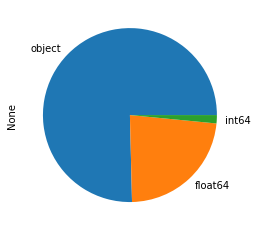

In [4]:
print(df.dtypes.value_counts())
df.dtypes.value_counts().plot.pie() ;

Notre dataframe comporte 49 variables de types catégorielles et 16 variables numériques.

In [5]:
df.columns

Index(['Code INSEE région', 'Région', 'Nature', 'Date', 'Heure',
       'Date - Heure', 'Consommation (MW)', 'Thermique (MW)', 'Nucléaire (MW)',
       'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)', 'Pompage (MW)',
       'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Flux physiques d'Auvergne-Rhône-Alpes vers Grand-Est',
       'Flux physiques de Bourgogne-Franche-Comté vers Grand-Est',
       'Flux physiques de Bretagne vers Grand-Est',
       'Flux physiques de Centre-Val de Loire vers Grand-Est',
       'Flux physiques de Grand-Est vers Grand-Est',
       'Flux physiques de Hauts-de-France vers Grand-Est',
       'Flux physiques d'Ile-de-France vers Grand-Est',
       'Flux physiques de Normandie vers Grand-Est',
       'Flux physiques de Nouvelle-Aquitaine vers Grand-Est',
       'Flux physiques d'Occitanie vers Grand-Est',
       'Flux physiques de Pays-de-la-Loire vers Grand-Est',
       'Flux physiques de PACA vers Grand-Est',
       'Flux physiques de Grand-Est vers Au

#### Précision
- **Flux physiques de <Région1> vers <Région2>** : somme des envois en MW de région1 vers région2 
- **Ech. physiques : solde des imports / exports en mw**
- **TCO <filière> %** : Taux de couverture de <filière> en % (je le traduis comme étant : production<filière> / production totale)
- **TCH <filière> %** : Taux de charge de <filière> en % (volume de prod / capacité de prod max en service)
- **Date** = date sous format date time
- **Consommation_mw** = total consommation en mw (quantitatif)
- **Production totale** = les 6 filières en mw (quantitatif)
- **Pompage** = technique de stockage de mw pour gérer le delta entre consommation production (quantitatif)
- **Région** : nom des régions fr (catégoriel)
- **code_insee_region** : code des régions (catégoriel)


**Définitions** : 
Facteur de charge : rapport entre l'électricité effectivement produite par la filière et celle qu'elle aurait pu produire si elle avait fonctionné à sa puissance maximale théorique durant la même période
Taux de couverture : part de la consommation couverte par la production de la filière

*Les flux interrégionaux d’électricité* :
Le solde des flux interrégionaux d'électricité est établi sur la base de données de transit télémesurées sur les lignes du réseau public de transport d’électricité (RPT). Ces données sont complétées par une estimation des flux ayant cours sur les réseaux en aval du RPT effectuée à partir des informations transmises par les entreprises de distribution (Enedis et les Entreprises Locales de Distribution). RTE a développé des algorithmes permettant d’estimer les flux interrégionaux sur les réseaux de distribution pour lesquels l'entreprise ne possède pas de télémesure.

In [6]:
## UTILISATION DES DEFINITIONS CREEES DANS UTILS.PY (importer précédemment)
## EFFET RECHERCHE : Normalisation des noms des colonnes

liste_code_ok = utils.code_region_pays(df.columns)
liste_normalize = utils.normalize(liste_code_ok)
liste_trad = utils.list_to_dict(liste_normalize)

df = df.set_axis([i for i in range(0,65)], axis=1, inplace=False)
df = df.rename(columns=liste_trad)

df.columns

Index(['code_insee_region', 'region', 'nature', 'date', 'heure', 'date_heure',
       'consommation_mw', 'thermique_mw', 'nucleaire_mw', 'eolien_mw',
       'solaire_mw', 'hydraulique_mw', 'pompage_mw', 'bioenergies_mw',
       'ech._physiques_mw', 'fp_de_84_vers_44', 'fp_de_27_vers_44',
       'fp_de_53_vers_44', 'fp_de_24_vers_44', 'fp_de_44_vers_44',
       'fp_de_32_vers_44', 'fp_de_11_vers_44', 'fp_de_28_vers_44',
       'fp_de_75_vers_44', 'fp_de_76_vers_44', 'fp_de_52_vers_44',
       'fp_de_93_vers_44', 'fp_de_44_vers_84', 'fp_de_44_vers_27',
       'fp_de_44_vers_53', 'fp_de_44_vers_24', 'fp_de_44_vers_44.1',
       'fp_de_44_vers_32', 'fp_de_44_vers_11', 'fp_de_44_vers_28',
       'fp_de_44_vers_75', 'fp_de_44_vers_76', 'fp_de_44_vers_52',
       'fp_de_44_vers_93', 'fp_de_vers_44', 'fp_be_vers_44', 'fp_es_vers_44',
       'fp_it_vers_44', 'fp_lu_vers_44', 'fp_gb_vers_44', 'fp_ch_vers_44',
       'fp_de_44_vers_de', 'fp_de_44_vers_be', 'fp_de_44_vers_es',
       'fp_de_44_ver

# AFFICHAGE DES % DE NAN PAR COLONNE

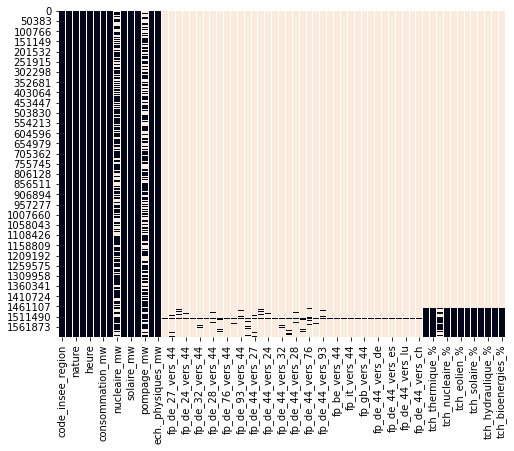

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isna(), cbar=False);
#cbar=False

Notre  observation confirme que le dataframe dispose de beaucoup de valeurs manquantes.
Toute la partie blanche représente des valeurs manquantes. 
On peut afficher les proportions en pourcentage pour mieux voir. 

In [8]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

fp_de_76_vers_44      0.992765
fp_de_44_vers_44      0.992765
fp_de_44_vers_be      0.992765
fp_de_44_vers_de      0.992765
fp_ch_vers_44         0.992765
fp_gb_vers_44         0.992765
fp_lu_vers_44         0.992765
fp_it_vers_44         0.992765
fp_es_vers_44         0.992765
fp_be_vers_44         0.992765
fp_de_vers_44         0.992765
fp_de_44_vers_lu      0.992765
fp_de_44_vers_44.1    0.992765
fp_de_44_vers_it      0.992765
fp_de_11_vers_44      0.992765
fp_de_44_vers_es      0.992765
fp_de_84_vers_44      0.992765
fp_de_44_vers_gb      0.992765
fp_de_44_vers_ch      0.992765
fp_de_27_vers_44      0.985531
fp_de_44_vers_53      0.985531
fp_de_44_vers_93      0.985531
fp_de_44_vers_52      0.985531
fp_de_44_vers_76      0.985531
fp_de_44_vers_75      0.985531
fp_de_44_vers_28      0.985531
fp_de_44_vers_11      0.985531
fp_de_53_vers_44      0.985531
fp_de_44_vers_24      0.985531
fp_de_44_vers_32      0.985531
fp_de_44_vers_27      0.985531
fp_de_24_vers_44      0.985531
fp_de_44

On peut maintenant procéder au nettoyage de notre dataframe.

**le TCO & TCH est une donnée récente** : pas de données sur 2013 et 2019 et très disparate sur 2021. Choix de l'Equipe : Suppression de cette donnée. 
**Les flux physiques par région présente trop de NaN**, nous conservont cependant le SOLDE IMPORT / EXPORT qui ne présente pas trop de NaN.
    
A voir peut être pour obtenir une constante pour la calculer nous même. 

## Nous conservons donc les données ayant moins de 90% de NaN

In [9]:
#on supprime les colonnes de flux physiques de notre étude et de TCO et TCH

data_clean = df.iloc[:,0:15]
(data_clean.isna().sum()/data_clean.shape[0]).sort_values(ascending=False)

pompage_mw           0.438405
nucleaire_mw         0.416671
eolien_mw            0.000067
consommation_mw      0.000007
thermique_mw         0.000007
solaire_mw           0.000007
hydraulique_mw       0.000007
bioenergies_mw       0.000007
ech._physiques_mw    0.000007
code_insee_region    0.000000
region               0.000000
nature               0.000000
date                 0.000000
heure                0.000000
date_heure           0.000000
dtype: float64

## CHECK DES NaN ayant 0.000007

In [10]:
print(data_clean[data_clean['bioenergies_mw'].isna()]['date'].value_counts())
print(data_clean[data_clean['hydraulique_mw'].isna()]['date'].value_counts())
print(data_clean[data_clean['solaire_mw'].isna()]['date'].value_counts())
print(data_clean[data_clean['thermique_mw'].isna()]['date'].value_counts())

#les 12 premières lignes du dataset : 1er janvier à minuit sont égal à 0. on peut supprimer ces lignes

data_clean = data_clean.drop(axis=0, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

#réinialisation de l'indexation
data_clean.reset_index(inplace=True, drop=True)

(data_clean.isna().sum()/data_clean.shape[0]).sort_values(ascending=False)

2013-01-01    12
Name: date, dtype: int64
2013-01-01    12
Name: date, dtype: int64
2013-01-01    12
Name: date, dtype: int64
2013-01-01    12
Name: date, dtype: int64


pompage_mw           0.438401
nucleaire_mw         0.416667
eolien_mw            0.000060
code_insee_region    0.000000
region               0.000000
nature               0.000000
date                 0.000000
heure                0.000000
date_heure           0.000000
consommation_mw      0.000000
thermique_mw         0.000000
solaire_mw           0.000000
hydraulique_mw       0.000000
bioenergies_mw       0.000000
ech._physiques_mw    0.000000
dtype: float64

# Remplacement des NaN restant :

**pompage** : remplacement à 0 car ce sont les régions où il n'y en a pas

**nucléaire** : idem : il s'agit des régions où il n'y a pas de central donc 0

**éolien** : idem

In [11]:
data_clean[data_clean['pompage_mw'].isna()]['region'].value_counts()
#changement à 0 - quand NaN : pas de production détectée

data_clean['pompage_mw'] = data_clean['pompage_mw'].fillna(0)

In [12]:
data_clean[data_clean['nucleaire_mw'].isna()]['region'].value_counts()
#région où il n'y a pas de central nucléaire
data_clean['nucleaire_mw'] = data_clean['nucleaire_mw'].fillna(0)
data_clean[data_clean['nucleaire_mw'].isna()]['region'].value_counts()

Series([], Name: region, dtype: int64)

In [13]:
data_clean[data_clean['eolien_mw'].isna()]['date'].value_counts()
# peu de données par rapport au total du dataset : remplacement par 0 ok
data_clean['eolien_mw'] = data_clean['eolien_mw'].fillna(0)

In [14]:
(data_clean.isna().sum()/data_clean.shape[0]).sort_values(ascending=False)

code_insee_region    0.0
region               0.0
nature               0.0
date                 0.0
heure                0.0
date_heure           0.0
consommation_mw      0.0
thermique_mw         0.0
nucleaire_mw         0.0
eolien_mw            0.0
solaire_mw           0.0
hydraulique_mw       0.0
pompage_mw           0.0
bioenergies_mw       0.0
ech._physiques_mw    0.0
dtype: float64

La variable cible contient des valeurs manquantes, on peut les supprimer.

In [15]:
(data_clean.isna().sum()/data_clean.shape[0]).sort_values(ascending=False)

code_insee_region    0.0
region               0.0
nature               0.0
date                 0.0
heure                0.0
date_heure           0.0
consommation_mw      0.0
thermique_mw         0.0
nucleaire_mw         0.0
eolien_mw            0.0
solaire_mw           0.0
hydraulique_mw       0.0
pompage_mw           0.0
bioenergies_mw       0.0
ech._physiques_mw    0.0
dtype: float64

On n'a plus de valeurs manquantes.

In [16]:
(data_clean.isna().sum()/data_clean.shape[0]).sort_values(ascending=False)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612212 entries, 0 to 1612211
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   code_insee_region  1612212 non-null  int64  
 1   region             1612212 non-null  object 
 2   nature             1612212 non-null  object 
 3   date               1612212 non-null  object 
 4   heure              1612212 non-null  object 
 5   date_heure         1612212 non-null  object 
 6   consommation_mw    1612212 non-null  float64
 7   thermique_mw       1612212 non-null  float64
 8   nucleaire_mw       1612212 non-null  float64
 9   eolien_mw          1612212 non-null  float64
 10  solaire_mw         1612212 non-null  float64
 11  hydraulique_mw     1612212 non-null  float64
 12  pompage_mw         1612212 non-null  float64
 13  bioenergies_mw     1612212 non-null  float64
 14  ech._physiques_mw  1612212 non-null  float64
dtypes: float64(9), int64(1), object(

In [17]:
data_clean.head(20)

,code_insee_region,region,nature,date,heure,date_heure,consommation_mw,thermique_mw,nucleaire_mw,eolien_mw,solaire_mw,hydraulique_mw,pompage_mw,bioenergies_mw,ech._physiques_mw
0,53,Bretagne,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,3050.0,58.0,0.0,107.0,0.0,86.0,-1.0,20.0,2779.0
1,11,Île-de-France,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,9134.0,685.0,0.0,16.0,0.0,0.0,0.0,142.0,8289.0
2,75,Nouvelle-Aquitaine,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,5464.0,240.0,4993.0,175.0,0.0,427.0,0.0,142.0,-518.0
3,28,Normandie,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,3683.0,432.0,8200.0,216.0,0.0,12.0,0.0,54.0,-5233.0
4,27,Bourgogne-Franche-Comté,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,2357.0,236.0,0.0,106.0,0.0,105.0,0.0,12.0,1894.0
5,84,Auvergne-Rhône-Alpes,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,8173.0,252.0,12069.0,257.0,0.0,3079.0,-4.0,68.0,-7551.0
6,44,Grand Est,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,4943.0,319.0,9137.0,1109.0,0.0,1418.0,0.0,57.0,-7102.0
7,24,Centre-Val de Loire,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,2476.0,90.0,9085.0,508.0,0.0,34.0,0.0,25.0,-7267.0
8,32,Hauts-de-France,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,5989.0,828.0,4499.0,1115.0,0.0,1.0,0.0,69.0,-525.0
9,52,Pays de la Loire,Données définitives,2013-01-01,00:30,2013-01-01T00:30:00+01:00,3595.0,127.0,0.0,182.0,0.0,0.0,0.0,32.0,3252.0


-**Création d'une colonne totale production pour faciliter vizu**

-**changement type de la 'date' to datetime pour faciliter le grab de données tempo**

In [18]:
#Création colonne totale production

data_clean['prod_totale'] = (data_clean['bioenergies_mw'] 
                            + data_clean['hydraulique_mw'] 
                            + data_clean['solaire_mw']
                            + data_clean['eolien_mw']
                            + data_clean['nucleaire_mw']
                            + data_clean['thermique_mw'])

data_clean.columns

##TO DATETIME
data_clean['date'] =  pd.to_datetime(data_clean['date'])
data_clean['heure'] =  pd.to_datetime(data_clean['heure'])
data_clean['date_heure'] =  pd.to_datetime(data_clean['date_heure'], utc=True)



print(data_clean.info()) #ok date time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612212 entries, 0 to 1612211
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   code_insee_region  1612212 non-null  int64              
 1   region             1612212 non-null  object             
 2   nature             1612212 non-null  object             
 3   date               1612212 non-null  datetime64[ns]     
 4   heure              1612212 non-null  datetime64[ns]     
 5   date_heure         1612212 non-null  datetime64[ns, UTC]
 6   consommation_mw    1612212 non-null  float64            
 7   thermique_mw       1612212 non-null  float64            
 8   nucleaire_mw       1612212 non-null  float64            
 9   eolien_mw          1612212 non-null  float64            
 10  solaire_mw         1612212 non-null  float64            
 11  hydraulique_mw     1612212 non-null  float64            
 12  pompage_mw    

## Création de 3 autres dataframe par temporalité : Année, Mois, Jours

-**Ci - dessous suppression de 2021 pour travailler sur un bloc temporel sans 'trou'**

In [19]:
data_clean['year'] = data_clean['date'].apply(lambda x : x.year)

############## SUPPRESSION 2021 : 2020 pas de données#####################
data_clean = data_clean.loc[data_clean['year'] != 2021]
###########################################################################

data_clean['month'] = data_clean['date'].apply(lambda x : x.month)
data_clean['days'] = data_clean['date'].apply(lambda x : x.day)



print(data_clean['year'].unique())
print(data_clean['month'].unique())
print(data_clean['days'].unique())

data_clean_by_year = data_clean.groupby('year', as_index = False).sum()
data_clean_by_year = data_clean_by_year.drop(['month','days', 'code_insee_region'], axis = 1)

data_clean_by_month = data_clean.groupby(['year','month'], as_index = False).sum()
data_clean_by_month = data_clean_by_month.drop(['days', 'code_insee_region'], axis = 1)

data_clean_by_days = data_clean.groupby(['year', 'month', 'days'], as_index = False).sum()
data_clean_by_days = data_clean_by_days.drop(['code_insee_region'], axis = 1)

print(data_clean_by_year.head())
print(data_clean_by_month.head())
print(data_clean_by_days.head())

[2013 2014 2015 2016 2017 2018 2019]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
   year  consommation_mw  thermique_mw  nucleaire_mw   eolien_mw  solaire_mw  \
0  2013      984134263.0    87265040.0   806802087.0  31665608.0   9008891.0   
1  2014      924697156.0    49924365.0   831008785.0  34116918.0  11639659.0   
2  2015      946305720.0    66714884.0   832908808.0  42188171.0  14572733.0   
3  2016      960630996.0    88787737.0   767408645.0  41835426.0  16521789.0   
4  2017      958089446.0   105507116.0   757772631.0  48194982.0  17987913.0   

   hydraulique_mw  pompage_mw  bioenergies_mw  ech._physiques_mw   prod_totale  
0     149129252.0 -14366288.0      12227527.0        -98246706.0  1.096098e+09  
1     134720263.0 -15980203.0      15020879.0       -135740875.0  1.076431e+09  
2     117039522.0 -13776932.0      15832717.0       -129170409.0  1.089257e+09  
3     126717599.0 -13498

In [20]:
data_clean.to_csv('C:\\Users\\Nouz\\Desktop\\DATASCIENTEST\\Projet Energie\\data_clean.csv',index=False)
data_clean_by_year.to_csv('C:\\Users\\Nouz\\Desktop\\DATASCIENTEST\\Projet Energie\\data_clean_by_year.csv',index=False)
data_clean_by_month.to_csv('C:\\Users\\Nouz\\Desktop\\DATASCIENTEST\\Projet Energie\\data_clean_by_month.csv',index=False)
data_clean_by_days.to_csv('C:\\Users\\Nouz\\Desktop\\DATASCIENTEST\\Projet Energie\\data_clean_by_days.csv',index=False)